In [1]:
import matplotlib.pyplot as plt

from pywarper import Warper
import skeliner as sk
import numpy as np


In [2]:
from pywarper.utils import read_sumbul_et_al_chat_bands
# data from Sümbül et al. 2014
# https://github.com/uygarsumbul/rgc
chat_top = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-TopBand-Mike.txt", unit="physical") # should be the off sac layer
chat_bottom = read_sumbul_et_al_chat_bands("../tests/data/Image013-009_01_ChAT-BottomBand-Mike.txt", unit="physical") # should be the on sac layer
# but the image can be flipped
if chat_top["z"].mean() > chat_bottom["z"].mean():
    off_sac = chat_top
    on_sac = chat_bottom
else:
    off_sac = chat_bottom
    on_sac = chat_top

In [3]:
cell_path = "../tests/data/Image013-009_01_raw_latest_Uygar.swc"
w = Warper(off_sac=off_sac, on_sac=on_sac, swc_path=cell_path, verbose=True)
voxel_resolution = np.array([0.4, 0.4, 0.5])  # in microns
w.skel.nodes *= voxel_resolution # convert to microns

# in the original matlab code, all data were in voxel space and converted to microns at the end
# but it makes more sense to work in microns from the beginning, so that there will be less unit conversion in between

[pywarper] Loading arbor → ../tests/data/Image013-009_01_raw_latest_Uygar.swc


In [4]:
w.fit_surfaces()
w.build_mapping()
w.warp_arbor()

[pywarper] Fitting SAC surfaces …
↳ fitting OFF (max) surface
    done in 0.07 seconds.
↳ fitting ON (min) surface
    done in 0.07 seconds.
[pywarper] Building mapping …
↳ mapping ON (min) surface …
    done in 0.07 seconds.
↳ mapping OFF (max) surface …
    done in 0.06 seconds.
[pywarper] Warping arbor...
    done in 1.30 seconds.


[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


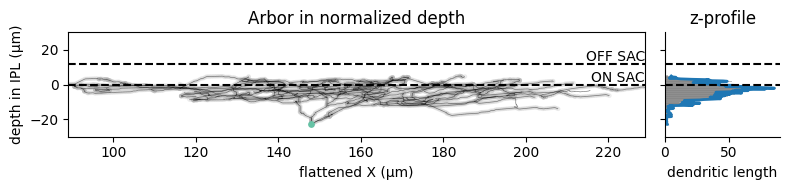

In [5]:
fig, (ax_nodes, ax_prof) = plt.subplots(
    1, 2,
    figsize=(8, 2),
    sharey=True,                 # align the y-axes
    gridspec_kw={'width_ratios': [5, 1]}
)

# --- left: flattened arbor ----------------------------------------
sk.plot2d(w.warped_arbor, plane="xz",
          ax=ax_nodes, color_by="ntype", skel_cmap="Set2", 
          ylim=(-30, 30))
ax_nodes.set_xlabel('flattened X (µm)')
ax_nodes.set_ylabel('depth in IPL (µm)')
ax_nodes.set_title('Arbor in normalized depth')

# guide lines at ON / OFF SAC
for y in (0, 12):
    ax_nodes.axhline(y, ls='--', c='k')
ax_nodes.text(ax_nodes.get_xlim()[1], 0,
              'ON SAC', va='bottom', ha='right', fontsize=10)
ax_nodes.text(ax_nodes.get_xlim()[1], 12,
              'OFF SAC', va='bottom', ha='right', fontsize=10)

z_profile = w.warped_arbor.extra["z_profile"]
z_dist = z_profile["z_dist"]
z_x = z_profile["z_x"]
z_hist = z_profile["z_hist"]
# --- right: depth profile (horizontal) ----------------------------
ax_prof.plot(z_dist, z_x, lw=2, c='tab:blue')
ax_prof.barh(z_x, z_hist, color="gray", alpha=0.5)
ax_prof.set_xlabel('dendritic length')
ax_prof.set_title('z-profile')
ax_prof.axhline(0,  ls='--', c='k')
ax_prof.axhline(12, ls='--', c='k')

# remove unneeded spines to tidy the small panel
ax_prof.spines['top'].set_visible(False)
ax_prof.spines['right'].set_visible(False)

for ax in (ax_nodes, ax_prof):
    ax.set_aspect('auto') 

fig.tight_layout()
plt.show()

In [6]:
from pywarper.stats import get_convex_hull, get_hull_centroid, get_xy_center_of_mass

hull = get_convex_hull(w.warped_arbor.nodes[:, 0:2])
com_hull = get_hull_centroid(hull)

xy_profile = w.warped_arbor.extra["xy_profile"]
xy_dist = xy_profile["xy_dist"]
xy_x = xy_profile["xy_x"]
xy_y = xy_profile["xy_y"]
com_xy = get_xy_center_of_mass(xy_x, xy_y, xy_dist)

[skeliner] Warning: 58 nodes have zero radius; they were ignored when picking the estimator.


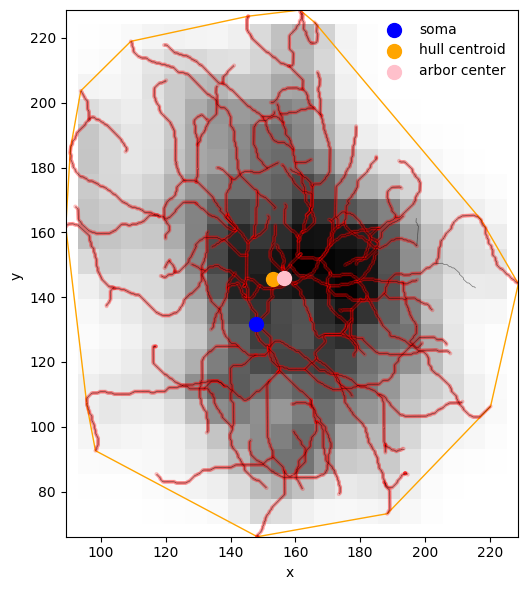

In [7]:
from matplotlib.colors import Normalize
fig, ax = plt.subplots(figsize=(6, 6))

im = ax.imshow(
    xy_dist.T, origin="lower",
    extent=[xy_x[0], xy_x[-1], xy_y[0], xy_y[-1]],
    cmap="Greys", norm=Normalize(vmin=0, vmax=xy_dist.max()),
)

sk.plot2d(
    w.warped_arbor, plane="xy", ax=ax,
)
ax.scatter(
    w.warped_arbor.nodes[0, 0],
    w.warped_arbor.nodes[0, 1],
    s=100, color='blue', zorder=99, label='soma',
)

ax.scatter(
    com_hull[0], com_hull[1],
    s=100, color='orange', zorder=99, label='hull centroid'
)

ax.scatter(
    com_xy[0], com_xy[1],
    s=100, color='pink', zorder=99, label='arbor center'
)

plt.fill(hull[:, 0], hull[:, 1], facecolor="none", edgecolor="orange", linewidth=1)

ax.legend(frameon=False)

In [8]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-06-12 23:42:16CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.3.0

numpy     : 2.2.6
skeliner  : 0.1.3
pywarper  : 0.1.9
matplotlib: 3.10.3

Watermark: 2.5.0

